In [434]:
import numpy as np
from matplotlib import pyplot as plt
import pywt
from modulations import *

In [435]:
message = np.random.randint(0,255,size=64)
# message = b"This is a test message to be compressed"
qam16 = QAM(16)


In [436]:
qam16_arr = np.array(list(qam16.values()))


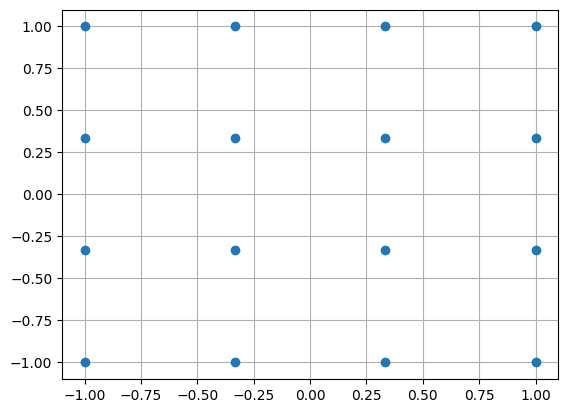

In [437]:
plt.plot(qam16_arr.real,qam16_arr.imag,'o')
plt.grid()
plt.show()

In [438]:
nibbles = bytes_to_nibbles(message)

print(nibbles)

[6, 0, 11, 10, 4, 6, 15, 1, 3, 13, 14, 1, 15, 14, 5, 6, 2, 12, 1, 5, 5, 14, 5, 4, 11, 11, 14, 9, 14, 15, 5, 15, 3, 1, 13, 7, 6, 13, 12, 2, 15, 13, 2, 8, 13, 13, 8, 5, 8, 1, 15, 8, 3, 1, 11, 2, 0, 13, 11, 3, 7, 9, 11, 2, 6, 7, 3, 5, 4, 3, 14, 8, 7, 6, 11, 13, 10, 3, 8, 0, 0, 3, 9, 11, 5, 9, 3, 13, 13, 15, 5, 8, 7, 15, 5, 11, 2, 7, 3, 2, 1, 7, 12, 5, 8, 4, 8, 7, 7, 7, 12, 15, 3, 1, 7, 11, 2, 15, 0, 5, 10, 4, 13, 6, 2, 14, 11, 0]


In [439]:
def extend(syms,n):
    result = []
    for s in syms:
        for i in range(n):
            result.append(s)

    return np.array(result,dtype=np.uint8)

In [440]:
symbols = extend(nibbles,10)
print(symbols)

[6 6 6 ... 0 0 0]


In [441]:
rf_data = np.zeros((1,len(symbols)),dtype=np.complex64)

for i in range(len(symbols)):
    rf_data[0][i] = qam16[symbols[i]]
    

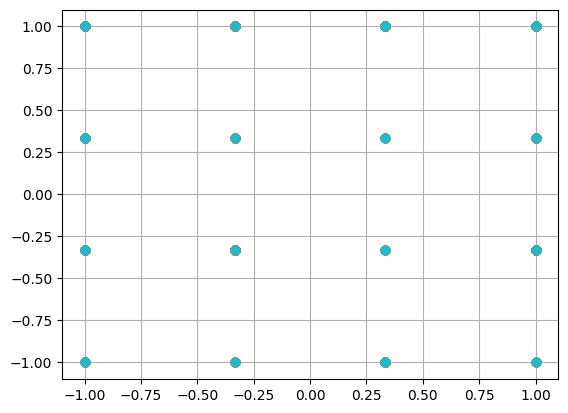

In [442]:
plt.plot(rf_data.real,rf_data.imag,'o')
plt.grid()
plt.show()

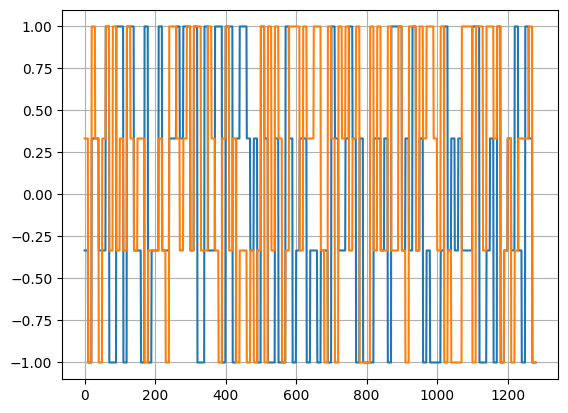

1280


In [443]:
plt.plot(rf_data[0].real)
plt.plot(rf_data[0].imag)
plt.grid()
plt.show()  
print(len(rf_data[0]))

In [444]:
# noise + channel
noise = np.random.normal(0,0.1,len(rf_data[0]))

In [445]:
def change_dynamic_range(s, in_min, in_max, out_min, out_max):
    return np.round((s - in_min) / (in_max - in_min) * (out_max - out_min) + out_min)



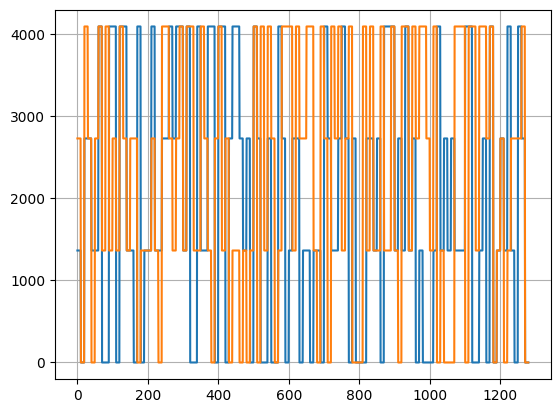

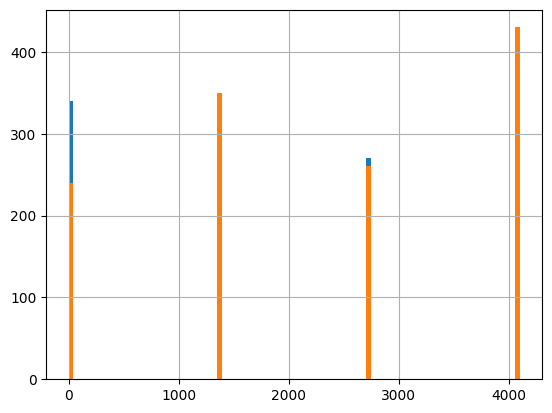

[1365.0, 0.0, 2731.0, 4096.0]


In [446]:
rf_12_bits_real = change_dynamic_range(rf_data[0].real, -1, 1, 0, 1<<12)
rf_12_bits_imag = change_dynamic_range(rf_data[0].imag, -1, 1, 0, 1<<12)
rf_12_bits = rf_12_bits_real + 1j*rf_12_bits_imag
plt.plot(rf_12_bits.real)
plt.plot(rf_12_bits.imag)
plt.grid()
plt.show()
plt.hist(rf_12_bits_real,bins=100)
plt.hist(rf_12_bits_imag,bins=100)
plt.grid()
plt.show()
bins = []
for bin in rf_12_bits_real:
    
    if bin not in bins:
        bins.append(bin)
        
print(bins)
    

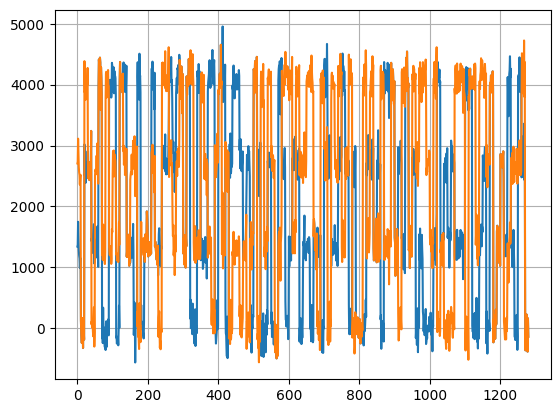

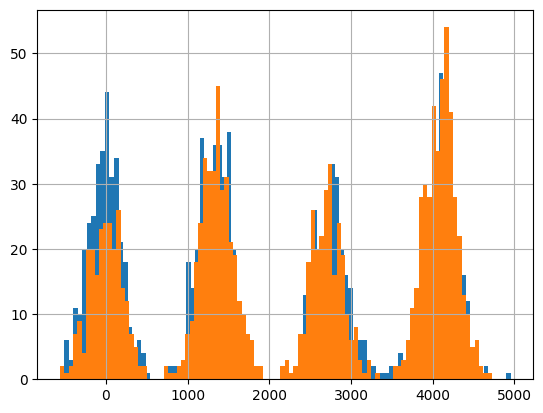

In [447]:
rf_noisy_real = rf_data[0].real + noise
rf_noisy_imag = rf_data[0].imag + noise
rf_noisy = rf_noisy_real + 1j*rf_noisy_imag
rf_12_bits_real_noisy = change_dynamic_range(rf_noisy_real, -1, 1, 0, 1<<12)
rf_12_bits_imag_noisy = change_dynamic_range(rf_noisy_imag, -1, 1, 0, 1<<12)
rf_12_bits_noisy = rf_12_bits_real_noisy + 1j*rf_12_bits_imag_noisy



plt.plot(rf_12_bits_noisy.real)
plt.plot(rf_12_bits_noisy.imag)
plt.grid()
plt.show()
plt.hist(rf_12_bits_noisy.real,bins=100)
plt.hist(rf_12_bits_noisy.imag,bins=100)
plt.grid()
plt.show()

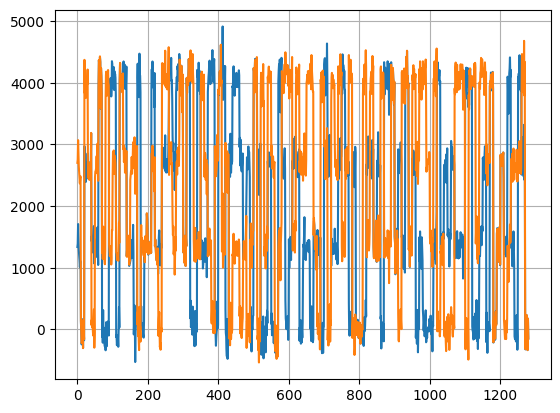

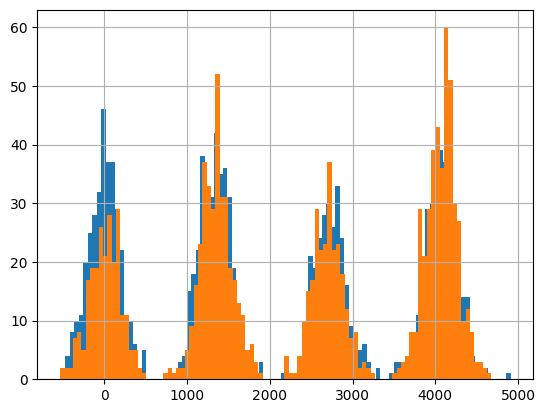

In [448]:
received = change_dynamic_range(rf_12_bits_noisy, 0, 1<<12, -1, 1)
# type(received)

def denoise(s):
    coeffs = pywt.wavedec(s,'db6',level=4)
    new_coeffs = coeffs.copy()
    thr=25
    method = 'soft'
    new_coeffs[0] = pywt.threshold(coeffs[0],thr,method)
    new_coeffs[1] = pywt.threshold(coeffs[1],thr,method)
    new_coeffs[2] = pywt.threshold(coeffs[2],thr,method)
    new_coeffs[3] = pywt.threshold(coeffs[3],thr,method)
    new_coeffs[4] = pywt.threshold(coeffs[4],thr,method)
    return pywt.waverec(new_coeffs,'db6')

received_real_dn = denoise(rf_12_bits_noisy.real) 
received_imag_dn = denoise(rf_12_bits_noisy.imag)
received_dn = received_real_dn + 1j*received_imag_dn
plt.plot(received_dn.real)
plt.plot(received_dn.imag)
plt.grid()
plt.show()
plt.hist(received_dn.real,bins=100)
plt.hist(received_dn.imag,bins=100)
plt.grid()
plt.show()

In [ ]:
with open("signals.npy","wb") as f:
    np.save(f,rf_data)
    np.save(f,rf_12_bits)
    np.save(f,rf_noisy)
    np.save(f,rf_12_bits_noisy)
    np.save(f,received_dn)

In [450]:
rec_dn = change_dynamic_range(received_dn, 0, 1<<12, -1, 1)
recovered = [QAM_demodulate(s,qam16) for s in rec_dn]
print(recovered[::10])
print(nibbles)

[7, 1, 7, 7, 5, 7, 15, 3, 3, 15, 15, 3, 15, 15, 7, 7, 3, 13, 3, 7, 7, 15, 7, 5, 7, 7, 15, 15, 15, 15, 7, 15, 3, 3, 15, 7, 7, 15, 13, 3, 15, 15, 3, 5, 15, 15, 5, 7, 5, 3, 15, 5, 3, 3, 7, 3, 1, 15, 7, 3, 7, 7, 7, 3, 3, 7, 3, 7, 5, 3, 15, 5, 7, 7, 7, 15, 7, 3, 5, 1, 1, 3, 7, 7, 7, 7, 3, 15, 15, 15, 7, 5, 7, 15, 7, 7, 3, 7, 3, 3, 3, 7, 13, 7, 5, 5, 5, 7, 7, 7, 13, 15, 3, 3, 7, 7, 3, 15, 1, 7, 7, 5, 15, 7, 3, 15, 7, 1]
[6, 0, 11, 10, 4, 6, 15, 1, 3, 13, 14, 1, 15, 14, 5, 6, 2, 12, 1, 5, 5, 14, 5, 4, 11, 11, 14, 9, 14, 15, 5, 15, 3, 1, 13, 7, 6, 13, 12, 2, 15, 13, 2, 8, 13, 13, 8, 5, 8, 1, 15, 8, 3, 1, 11, 2, 0, 13, 11, 3, 7, 9, 11, 2, 6, 7, 3, 5, 4, 3, 14, 8, 7, 6, 11, 13, 10, 3, 8, 0, 0, 3, 9, 11, 5, 9, 3, 13, 13, 15, 5, 8, 7, 15, 5, 11, 2, 7, 3, 2, 1, 7, 12, 5, 8, 4, 8, 7, 7, 7, 12, 15, 3, 1, 7, 11, 2, 15, 0, 5, 10, 4, 13, 6, 2, 14, 11, 0]


In [451]:
from sklearn.cluster import KMeans

[96, 186, 70, 241, 61, 225, 254, 86, 44, 21, 94, 84, 187, 233, 239, 95, 49, 215, 109, 194, 253, 40, 221, 133, 129, 248, 49, 178, 13, 179, 121, 178, 103, 53, 67, 232, 118, 189, 163, 128, 3, 155, 89, 61, 223, 88, 127, 91, 39, 50, 23, 197, 132, 135, 119, 207, 49, 123, 47, 5, 164, 214, 46, 176]
[ 96 186  70 241  61 225 254  86  44  21  94  84 187 233 239  95  49 215
 109 194 253  40 221 133 129 248  49 178  13 179 121 178 103  53  67 232
 118 189 163 128   3 155  89  61 223  88 127  91  39  50  23 197 132 135
 119 207  49 123  47   5 164 214  46 176]


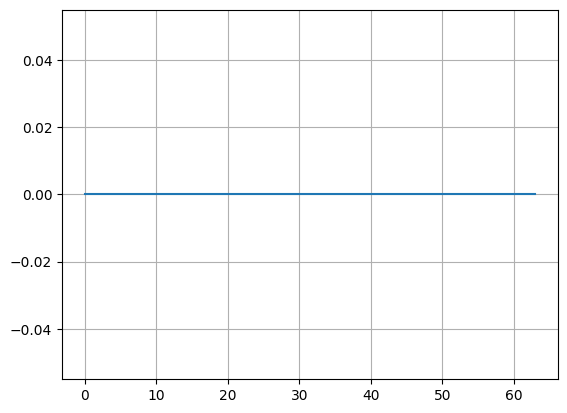

In [452]:
bytes = nibbles_to_bytes(nibbles)
print(bytes)
print(message)
difference = [int(b)-int(m) for b,m in zip(bytes,message)]
# plt.plot(message,label='message')
# plt.plot(bytes[0],label='bytes')
# plt.legend()
# plt.grid()
# plt.show()
plt.plot(difference)
plt.grid()
plt.show()